In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
pwd

'C:\\Users\\a_mcr\\Desktop\\Bootcamp\\Group_Projects\\gt-project3\\jupyter-lab'

In [3]:
df15 = pd.read_csv('../clean_csv_files/alvaro_15.csv')
df16 = pd.read_csv('../clean_csv_files/alvaro_16.csv')
df17 = pd.read_csv('../clean_csv_files/alvaro_17.csv')
df18 = pd.read_csv('../clean_csv_files/alvaro_18.csv')
df19 = pd.read_csv('../clean_csv_files/alvaro_19.csv')

In [4]:
df_combined_1 = pd.concat([df15, df16, df17, df18, df19])
df_combined_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4862 entries, 0 to 861
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rank            4862 non-null   int64  
 1   Name            4862 non-null   object 
 2   basename        4862 non-null   object 
 3   Genre           4862 non-null   object 
 4   ESRB_Rating     2356 non-null   object 
 5   Platform        4862 non-null   object 
 6   Publisher       4862 non-null   object 
 7   Developer       4862 non-null   object 
 8   VGChartz_Score  0 non-null      float64
 9   Critic_Score    417 non-null    float64
 10  User_Score      22 non-null     float64
 11  Total_Shipped   4862 non-null   float64
 12  Global_Sales    4862 non-null   float64
 13  NA_Sales        1904 non-null   float64
 14  PAL_Sales       2024 non-null   float64
 15  JP_Sales        2172 non-null   float64
 16  Other_Sales     2837 non-null   float64
 17  Year            4859 non-null   fl

In [5]:
# New dataframe containing data for preprocessing
df_new = df_combined_1[['Genre','Summary']].copy()
df_new

,Genre,Summary
0,Racing,
1,Action,Otogi 2: Immortal Warriors combines real-life ...
2,Simulation,
3,Action,For generations the peaceful cats of Yenching ...
4,Adventure,The best of scribblenauts comes together in th...
...,...,...
857,Simulation,
858,Shooter,"Infiltrate terrorists' positions, acquire crit..."
859,Fighting,
860,Adventure,


In [6]:
df_new['Genre'].value_counts()

Adventure           824
Misc                731
Action              621
Sports              397
Role-Playing        379
Racing              324
Simulation          306
Strategy            289
Shooter             272
Puzzle              233
Platform            164
Fighting            158
Visual Novel         74
Action-Adventure     48
Music                24
MMO                  11
Party                 6
Board Game            1
Name: Genre, dtype: int64

In [7]:
# combine genres with low counts into misc
# combine repeating genres, Action and Action
df_new.replace({'Genre': 
             {'Board Game':'Misc', 
              'Party':'Misc',
              'MMO': 'Misc',
              'Music': 'Misc'
#               'Adventure':'Action-Adventure', 
#               'Action':'Action-Adventure'
             }}, 
            inplace= True)
df_new['Genre'].value_counts()

Adventure           824
Misc                773
Action              621
Sports              397
Role-Playing        379
Racing              324
Simulation          306
Strategy            289
Shooter             272
Puzzle              233
Platform            164
Fighting            158
Visual Novel         74
Action-Adventure     48
Name: Genre, dtype: int64

In [8]:
# encode genres as a value in a new column
df_new['Genre_ID'] = df_new['Genre'].factorize()[0]
genre_df = df_new[['Genre', 'Genre_ID']].drop_duplicates()
# genre_df
df_new.head()

,Genre,Summary,Genre_ID
0,Racing,,0
1,Action,Otogi 2: Immortal Warriors combines real-life ...,1
2,Simulation,,2
3,Action,For generations the peaceful cats of Yenching ...,1
4,Adventure,The best of scribblenauts comes together in th...,3


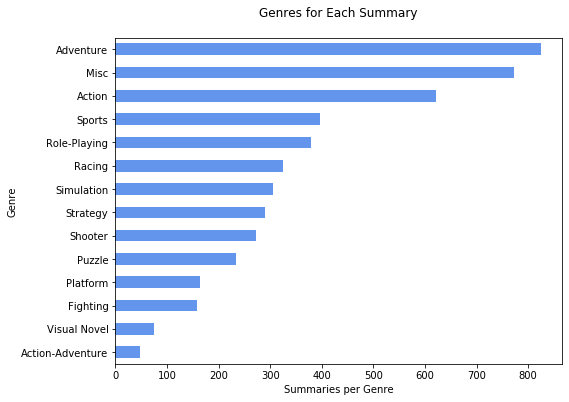

In [9]:
# fig = plt.figure(figsize=(8,6))
# df_new.groupby('Genre').Summary.count().sort_values().plot.barh(
#     ylim=0, color='cornflowerblue', title= 'Genres for Each Summary\n')
# plt.xlabel('Summaries per Genre', fontsize = 10);

In [15]:
tfidf = TfidfVectorizer(sublinear_tf=True,
                        ngram_range=(1, 4), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df_new['Summary']).toarray()
labels = df_new['Genre_ID']


In [16]:
features.shape

(4862, 306514)

In [17]:
genre_to_id = dict(genre_df.values)
genre_to_id

{'Racing': 0,
 'Action': 1,
 'Simulation': 2,
 'Adventure': 3,
 'Platform': 4,
 'Strategy': 5,
 'Misc': 6,
 'Role-Playing': 7,
 'Puzzle': 8,
 'Visual Novel': 9,
 'Fighting': 10,
 'Shooter': 11,
 'Sports': 12,
 'Action-Adventure': 13}

In [18]:
id_to_genre = dict(genre_df[['Genre_ID', 'Genre']].values)
id_to_genre

{0: 'Racing',
 1: 'Action',
 2: 'Simulation',
 3: 'Adventure',
 4: 'Platform',
 5: 'Strategy',
 6: 'Misc',
 7: 'Role-Playing',
 8: 'Puzzle',
 9: 'Visual Novel',
 10: 'Fighting',
 11: 'Shooter',
 12: 'Sports',
 13: 'Action-Adventure'}

In [32]:
# extracting the most common single and double word-phrases (biigram) in each genre
N = 5
# wordcloud = []

for genre, genre_id in sorted(genre_to_id.items()):
    
#     unigram = {}
#     bigram = {}
#     trigram = {}
    
    features_chi2 = chi2(features, labels == genre_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#     data[genre] = unigrams
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#     data[genre] = bigrams
    trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
#     data[genre] = trigrams
        
    print("\nGenre: %s" %(genre))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))
    print("  * Most Correlated Trigrams are: %s" %(', '.join(trigrams[-N:])))
#     wordcloud.append(data)


Genre: Action
  * Most Correlated Unigrams are: yoku, musou, kung, action, fu
  * Most Correlated Bigrams are: released 1999, shin sangoku, kung fu, beat em, action game
  * Most Correlated Trigrams are: delta action game, yami delta action, shin sangoku musou, beat em game, action game developed

Genre: Action-Adventure
  * Most Correlated Unigrams are: frankenimpa, wolfimpa, drac, spongebob, impa
  * Most Correlated Bigrams are: frankenstein murray, save monster, story sony, drac pack, lost islands
  * Most Correlated Trigrams are: missions explore lost, frankenstein murray wayne, save monster friends, story sony pictures, reunite rest drac

Genre: Adventure
  * Most Correlated Unigrams are: 2010, japan, factory, idea, adventure
  * Most Correlated Bigrams are: factory released, japan 2010, idea factory, published idea, adventure game
  * Most Correlated Trigrams are: idea factory released, factory released japan, developed published idea, published idea factory, adventure game deve

In [25]:
wordcloud

[{'Action': ['sci fi action',
   'based puzzle game',
   'source ubisoft store',
   'person action adventure',
   'challenging mini games',
   'mini games play',
   'solid snake eater',
   'nintendo ds wireless',
   'nintendo ds touch',
   'www activision com',
   'game year edition',
   'single player missions',
   'gear solid snake',
   'released europe 2010',
   'series returns new',
   'using nintendo ds',
   'come face face',
   'half human half',
   'mode challenge friends',
   'unique mini games',
   'online multiplayer modes',
   'wii remote nunchuk',
   'adding realism evolved',
   'players exclusive mode',
   'uk germany peter',
   'battles completely unique',
   'maximize excitement scoring',
   'creating best gameplay',
   'introduced uk germany',
   'superstars life goalkeepers',
   'including managers pes',
   'uefa europa league',
   'passes speeding players',
   'roots create exciting',
   'game enhanced deliver',
   'change cause defenders',
   '3x new animations',
   